C:\Users\manur\AppData\Local\Temp\ipykernel_18136\2366796824.py:223: RuntimeWarning:

Mean of empty slice

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



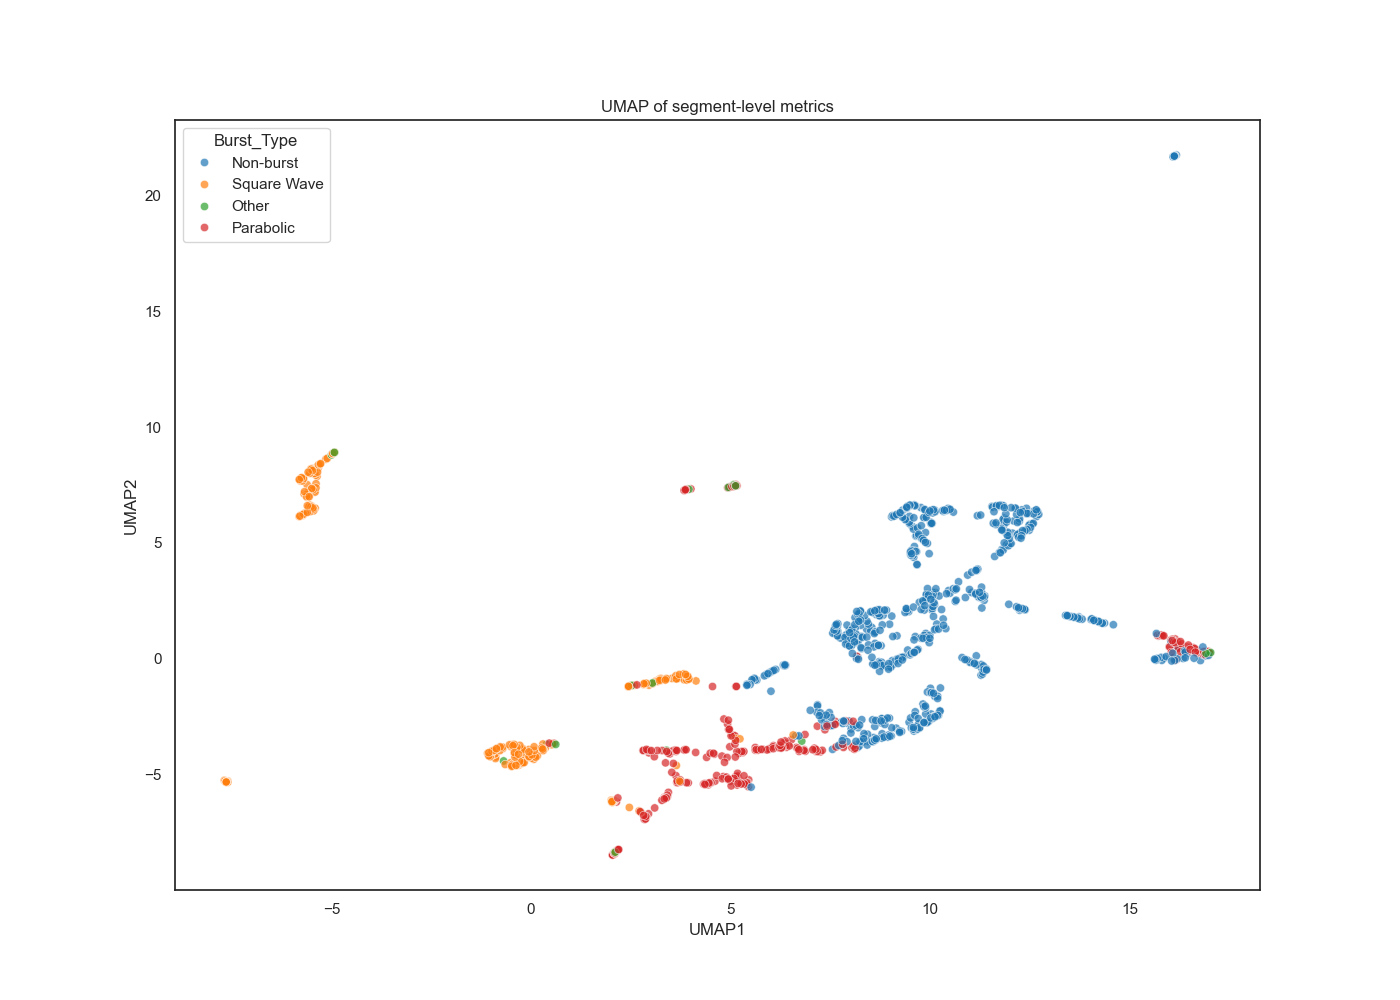

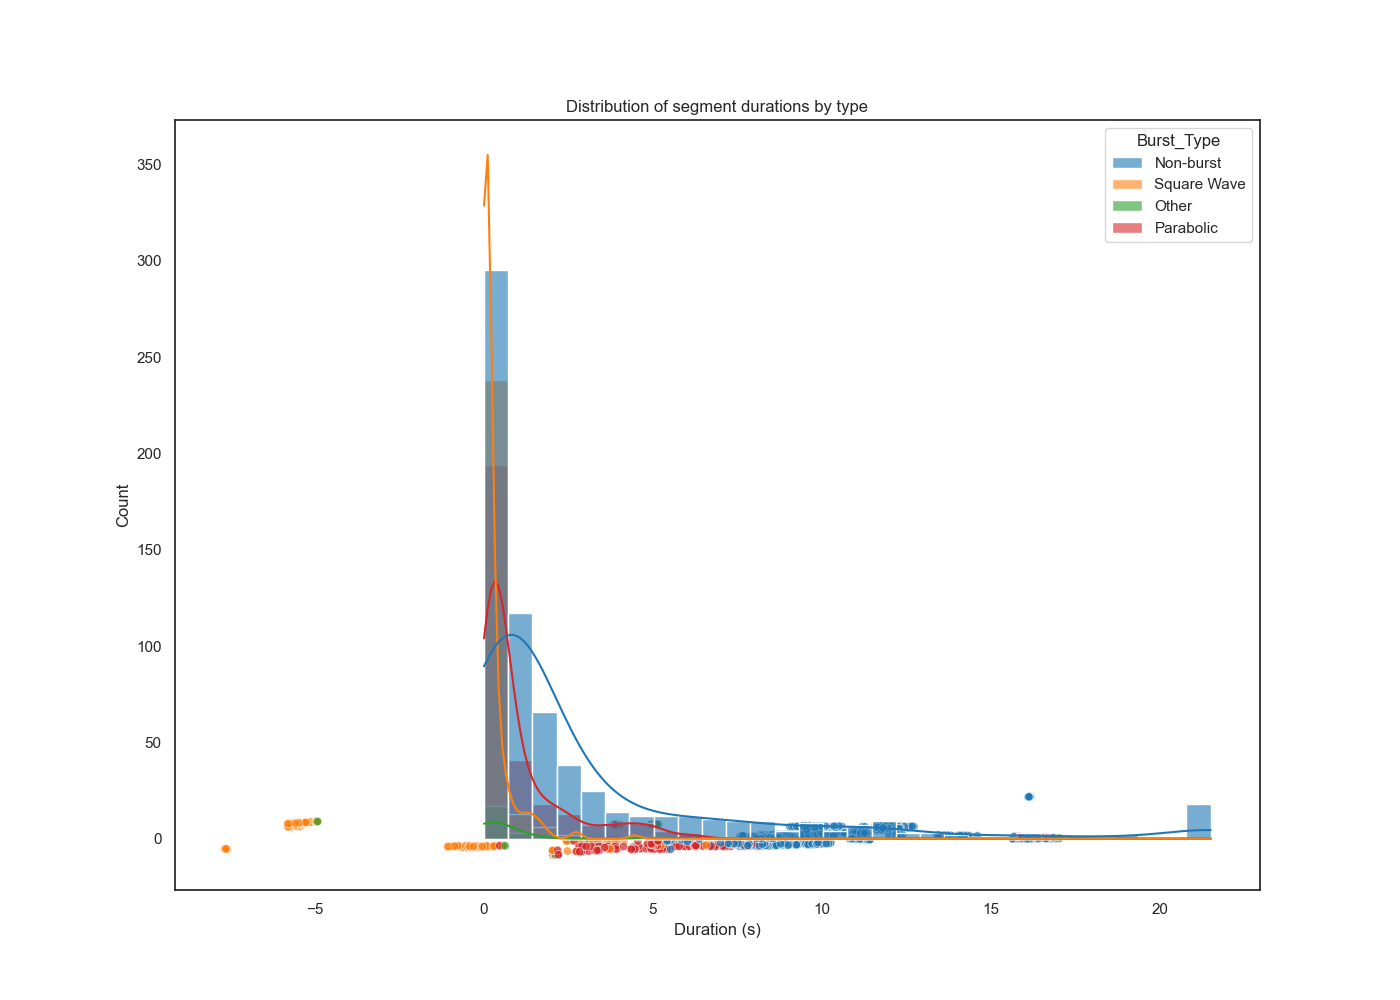

In [ ]:

# SEGMENT-LEVEL FEATURE EXTRACTION + UMAP



# - Basic utilities & file I/O
import os
# os is used to iterate directory contents and build paths portably between OSes.
# Alternative: pathlib.Path is more modern and often more convenient, but os works fine.


# - ABF reader and numeric libs

import pyabf
# pyabf reads Axon .abf electrophysiology files. It exposes sweeps, sample rate,
# and arrays for time/voltage. Be mindful that abf.sweepY is typically a numpy
# array but its dtype may depend on the file; always treat data as floats for math.

import numpy as np
# NumPy provides vectorized operations which are fast and memory-efficient when
# operated on contiguous arrays. Many operations below rely on fast broadcasting.

import pandas as pd
# pandas is convenient for tabular results and CSV export; it also integrates well
# with plotting libraries and downstream analysis.


# - Stats & signal processing
from scipy.stats import skew, kurtosis
# skew and kurtosis compute third and fourth central moment normalized metrics.
# These can be sensitive to outliers; consider robust measures (median absolute deviation)
# if your traces contain occasional large artefacts.

from scipy.signal import find_peaks
# find_peaks detects local maxima and supports many options (height, distance, prominence).
# We use simple height thresholding; in noisy data, consider also using 'prominence'
# to avoid counting baseline fluctuations as spikes.

# Enable interactive plotting in notebooks
%matplotlib widget


# Dimensionality reduction & preprocessing

# UMAP is useful to preserve local structure in high-dimensional features (nonlinear).
# We standardize features so each feature contributes similarly to distance metrics.
import umap
from sklearn.preprocessing import StandardScaler


# Plotting libraries

import matplotlib.pyplot as plt
import seaborn as sns      # nicer statistical plots
import plotly.express as px
import plotly.io as pio

# Force interactive plotly rendering to open the browser.
# Note: depending on your environment (Colab, VSCode, local Jupyter) you may need a different renderer.
pio.renderers.default = "browser"


# PARAMETERS, tune these to your data

folder_path = "bursting"   # directory containing .abf files
threshold = -35            # spike detection threshold in mV (peak height)
# Important: threshold should be chosen relative to your recording baseline.
# If recordings are baseline-shifted, either subtract baseline or choose threshold adaptively.

burst_threshold = 0.3      # ISI threshold in seconds: max gap to consider spikes in same burst
# Rationale: bursts are defined as spike clusters separated by short ISIs.
# This is a simple heuristic; alternatives: adaptive ISI thresholding, or methods based on ISI histograms.

fs = 10000                 # assumed sampling frequency (Hz) used for converting indices, seconds
# you can derive fs from abf.dataRate per-file instead of hardcoding; using abf.dataRate is safer.

dt = 1 / fs                # sample interval in seconds (used for integrations/derivatives)

# Container to accumulate per-segment feature vectors across files & sweeps
all_segment_metrics = []   # rows: [file, sweep, seg_type, burst_type, features...]


# File discovery

# We list all .abf files inside folder_path. If subdirectories matter, consider os.walk.
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

# Helpful safety check: if no files found, raise an informative error
if len(abf_files) == 0:
    raise FileNotFoundError(f"No .abf files found in folder '{folder_path}'. Check path.")


# Main loop: per-file, per-sweep processing

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    # Load the ABF file. pyabf.ABF reads header information lazily and provides methods to set sweeps.
    abf = pyabf.ABF(file_path)

    # You could also read sampling frequency from abf.dataRate here to avoid assuming fs.
    # Example: fs_file = abf.dataRate ; dt = 1.0 / fs_file

    # Loop each sweep (trial) in the ABF file
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)          # Load sweep-specific arrays into abf.sweepX and abf.sweepY
        time = abf.sweepX            # Time vector (seconds) for this sweep (recommended over manual fs)
        voltage = abf.sweepY.astype(float)  # Voltage trace; ensure float dtype for math


        # Spike detection

        # find_peaks returns local maxima indices. Here we use 'height' to require amplitude >= threshold.
        # If spikes are downward (negative-going), you should detect peaks in -voltage, or use trough detection.
        peaks, _ = find_peaks(voltage, height=threshold)
        # Convert sample indices to time (s). If using abf.sweepX, peaks map to indices along that vector.
        spike_times = peaks / fs   # if using abf.dataRate, do peaks / abf.dataRate instead

        # Edge cases:
        # - If no peaks found, spike_times is empty. Later code must handle this gracefully.
        # - If sampling freq differs across files, compute fs from abf.dataRate per-file.


        # Burst detection (simple ISI-based grouping)

        bursts = []  # will hold tuples (burst_start_time, burst_end_time)
        # Only attempt burst grouping if we have enough spikes to form a burst
        if len(spike_times) >= 4:  # arbitrary lower-bound: ensures meaningful bursts
            # Compute inter-spike intervals (ISI) in seconds
            isi = np.diff(spike_times)

            # We'll build bursts by accumulating spikes whose ISI < burst_threshold
            current_burst = [spike_times[0]]  # start with first spike time

            # Iterate through subsequent spikes, grouping by ISI
            for i in range(1, len(spike_times)):
                if isi[i - 1] < burst_threshold:
                    # The gap between spike i-1 and i is short, same burst
                    current_burst.append(spike_times[i])
                else:
                    # Gap too long, close previous burst (if it had >1 spike)
                    if len(current_burst) > 1:
                        bursts.append((current_burst[0], current_burst[-1]))
                    # Start a new burst accumulator with current spike
                    current_burst = [spike_times[i]]

            # After looping, save the final burst if valid
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))

        # Comments on burst detection choices:
        # - Using a fixed ISI threshold (0.3 s) is simple and interpretable.
        # - Pitfall: a single long ISI within a genuine burst can split it into two — more advanced
        #   algorithms allow limited gaps or use density-based clustering (e.g., DBSCAN on spike times).
        # - You may also detect bursts by sliding-window spike counts exceeding a threshold.

  
        # Build segments list: bursts and non-bursts

        segments = []  # each entry: (start_time, end_time, "Burst"/"Non-burst")

        # Add burst intervals
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        # If we detected bursts, build non-burst intervals around them; else entire trace is non-burst
        if bursts:
            # Non-burst before the first burst (if any lead time exists)
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))

            # Non-bursts between successive bursts
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))

            # Non-burst after last burst
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            # No bursts: whole sweep is marked as "Non-burst"
            segments.append((time[0], time[-1], "Non-burst"))

        # Note: segments are ordered chronological as built; ensuring that ordering is important
        # for computing baseline surrounding burst segments.


        # Classify burst types

        # Rationale: compare waveform minima inside a burst to the mean voltage outside the burst
        # If the minimum inside the burst is higher than surrounding baseline, "Square Wave"
        # If lower, "Parabolic"
        # Otherwise, "Other"
        burst_types = []  # parallel list to segments

        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                # Mask samples inside the burst
                seg_mask = (time >= seg_start) & (time <= seg_end)
                # Guard against empty masks (shouldn't happen if seg_start/end are within time)
                if not np.any(seg_mask):
                    burst_types.append("Other")
                    continue

                burst_min = np.min(voltage[seg_mask])

                # Compute baseline mean before and after this burst if available
                prev_mean = np.nan
                next_mean = np.nan

                # previous segment end (if exists)
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])

                # next segment start (if exists)
                if i < len(segments) - 1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])

                # Combine pre/post means, nanmean handles edge cases
                inter_mean = np.nanmean([prev_mean, next_mean])

                # Classification logic and its caveats
                if np.isnan(inter_mean):
                    # If we cannot compute baseline,
                    # classification is ambiguous, label as "Other".
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    # Burst minima is above surrounding baseline, a plateau-like (depolarized) burst
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    # Burst minima below baseline, parabolic / down-up pattern
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                # Non-burst segments are labeled explicitly
                burst_type = "Non-burst"

            burst_types.append(burst_type)


        # Compute metrics per segment

        # For each segment we compute:
        #  - duration
        #  - number of peaks within segment
        #  - mean ISI inside segment (if >=2 peaks)
        #  - voltage statistics (mean, std, min, max, skewness, kurtosis, area under curve)
        #  - derivative statistics (first difference / slope metrics)
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            # Mask the segment region
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]

            # Compute duration in seconds
            duration = seg_end - seg_start

            # Segment label (burst vs non-burst and refined burst type)
            burst_type = burst_types[j]

         
            # Peaks within the segment
        
            # Use same global threshold for consistent peak definition between segments
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            # convert peak indices (within segment) to times (global) by adding seg_start index offset if needed
            # Here we compute mean ISI inside segment in seconds (guard for <2 peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0
            # Note: seg_peaks are indices *within the segment array*, dividing by fs is approximate for ISI
            # A more accurate method would map seg_peaks to global sample indices.

    
            # Voltage-based statistics
   
            # Guard against short or empty segments
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                # Central tendency & dispersion
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                # Higher-order statistics: skewness and kurtosis
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                # Area under the curve: trapezoidal integration w.r.t time
                # We use dx=dt (sampling interval). If time vector is irregular, use np.trapz(y, x=time_segment).
                area_val = np.trapezoid(seg_voltage, dx=dt)

        
            # Derivative-based statistics
        
            # The derivative (first difference / slope) contains information about how fast the membrane potential changes.
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt  # units: mV / s (slope)
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)


            # Append the computed metrics for this segment to the global list

            # You can extend this list with any additional metrics you want.
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])


# After processing all files/sweeps: create DataFrame and save CSV

df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])

# Save to CSV for reproducibility and downstream analysis
out_csv = "segment_voltage_metrics_with_ISI_and_peaks.csv"
df_segments.to_csv(out_csv, index=False)


# UMAP section: dimensionality reduction for visualization and clustering

# Practical notes:
# - UMAP is sensitive to feature scaling and to outliers.
# - We standardize features to mean=0, std=1 to make distances meaningful across different feature ranges.
# - Consider selecting or engineering features more carefully for better embeddings.

sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

# Read CSV back (ensures the pipeline is reproducible; you could also use df_segments directly)
df = pd.read_csv(out_csv)

# Choose numeric feature columns for X. Here we start from column index 4 onward (drop metadata)
header = list(df)[4:]    # these are the feature column names
X = np.array(df[header], dtype=float)  # feature matrix (n_samples x n_features)
y = np.array(df.Burst_Type)            # labels for coloring/inspection


# Preprocessing: Standardize features

# StandardScaler subtracts mean and scales to unit variance per feature
# This avoids features with large numeric range dominating the embedding.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# UMAP embedding to 2D

# UMAP parameters (n_neighbors, min_dist) can substantially change output structure.
# The defaults are often reasonable for visualization; tune for clustering tasks.
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)  # result: (n_samples, 2)

# Build DataFrame with embedding coordinates and labels
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y


# Visualization 1: Seaborn scatter plot of UMAP embedding

# Seaborn provides a quick static visualization. Hue uses Burst_Type to color points.
sns.scatterplot(
    data=df_umap, x="UMAP1", y="UMAP2",
    hue="Burst_Type", palette="tab10", alpha=0.7
)
plt.title("UMAP of segment-level metrics")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


# Visualization 2: Histogram of segment durations, split by Burst_Type

sns.set(style="whitegrid", context="notebook", rc={'figure.figsize': (10, 6)})
sns.histplot(
    data=df_segments,
    x="Duration",
    hue="Burst_Type",
    bins=30,
    kde=True,
    palette="tab10",
    alpha=0.6
)
plt.title("Distribution of segment durations by type")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()


# Visualization 3: Interactive Plotly UMAP scatter

# Plotly allows hover, zoom, and exporting; we render in browser.
fig = px.scatter(
    df_umap, x="UMAP1", y="UMAP2",
    color="Burst_Type",
    title="UMAP (interactive)"
)
pio.renderers.default = "browser"
fig.show()